In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import glob
import lane_finding_pipeline as lfpipe
import constant
import os

# Camera Calibration

In [2]:
cmCalib = lfpipe.CameraCalibration()

found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found


# Distortion Correction

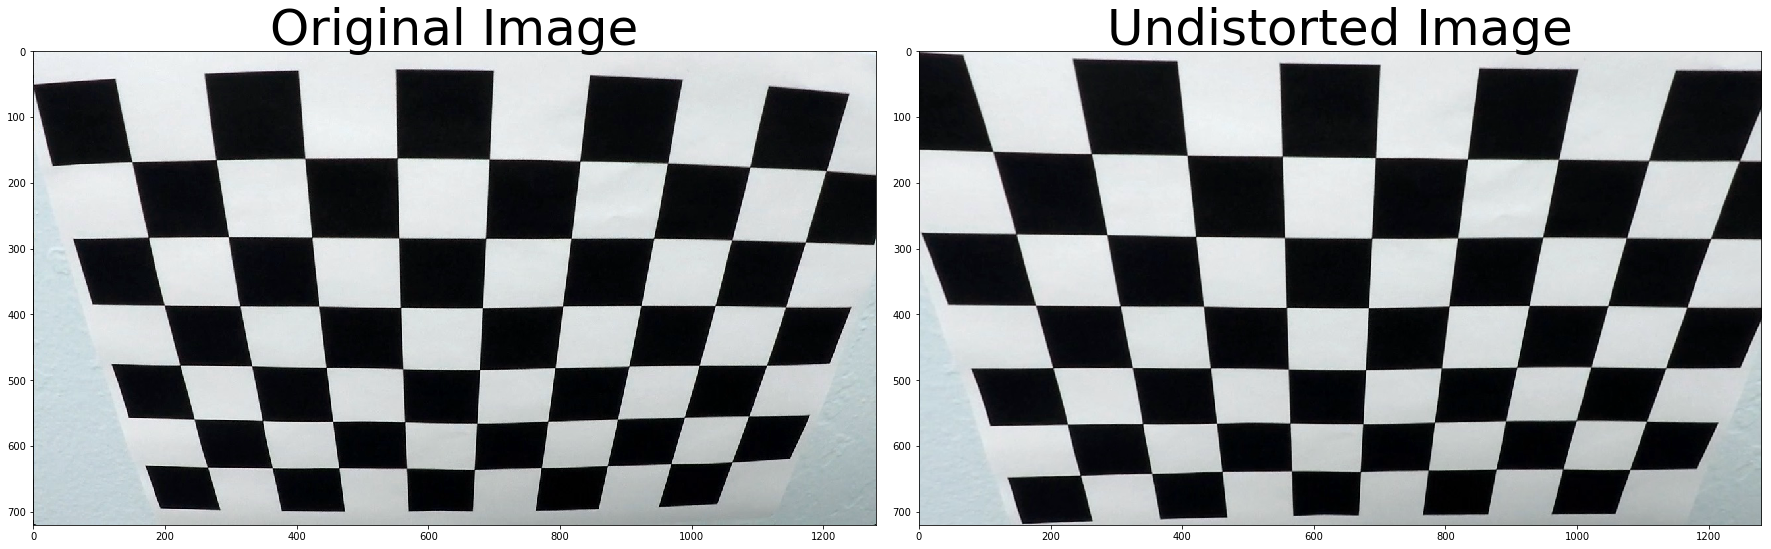

In [36]:

# test to see the camera calibration work
img = cv2.imread(os.path.join(constant.getCameraCalibrationFolderPath(), "calibration2.jpg"))
undistortImg = cmCalib.process(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistortImg)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f.savefig('output_images/distortion_corrected.jpg')

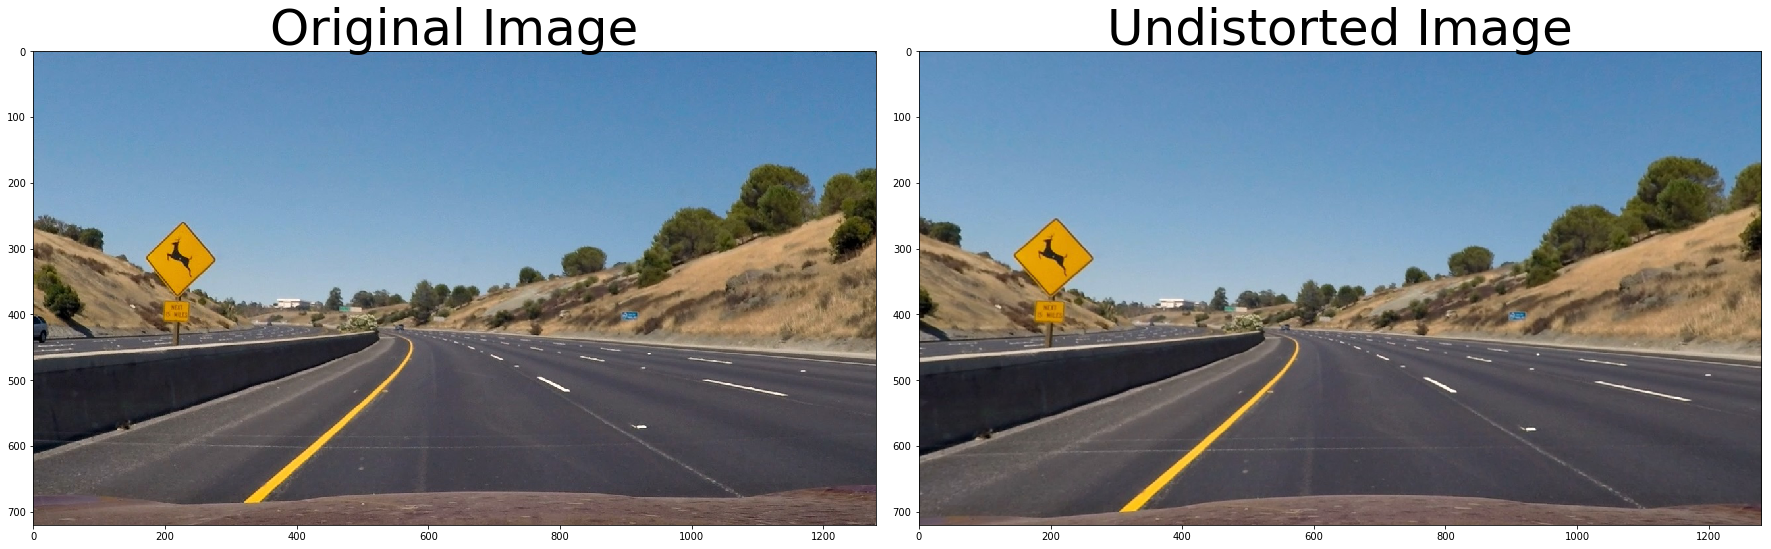

In [38]:
img = mpimg.imread('test_images/test2.jpg')
undistortedImg = cmCalib.process(img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistortedImg)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f.savefig('output_images/distortion_corrected_real.jpg')


# Gradient & Color Filtering

In [39]:
def get_threshold_image(image):
    '''
    input: img we need to process 
    output: gradient & color filter processes image
    '''
    
    # apply graident threshold on horizontal gradient
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    height, width = gray.shape
    
    gfilterX = lfpipe.SobelFilter('x', thresh_min=10, thresh_max=200)
    gfilterdir = lfpipe.SobelFilter('dir', thresh_min=np.pi/6, thresh_max=np.pi/2)
    
    combined_condition = (gfilterX.process(gray) == 1) & (gfilterdir.process(gray) == 1)
    
    # apply color filter 
    # R & G thresholds so that yellow lanes are detected well.
    color_combined = np.zeros_like(image[:, :, 0])

    rfilter = lfpipe.ColorFilter('R', min_thresh=150)
    gfilter = lfpipe.ColorFilter('G', min_thresh=150)
    
    rMask = rfilter.process(image)
    gMask = gfilter.process(image)
    
    r_g_condition = rMask & gMask
    
    
    lfilter = lfpipe.ColorFilter('L', min_thresh=100)
    sfilter = lfpipe.ColorFilter('S', min_thresh=120)
    
    smask, lmask = sfilter.process(image), lfilter.process(image)

    # combine all the thresholds
    # A pixel should either be a yellowish or whiteish
    # And it should also have a gradient, as per our thresholds
    color_combined[(r_g_condition& smask) & (lmask | combined_condition)] = 1
    
    # apply the region of interest mask
    mask = np.zeros_like(color_combined)
    region_of_interest_vertices = np.array([[0,height-1], [width/2, int(0.5*height)], [width-1, height-1]], dtype=np.int32)
    cv2.fillPoly(mask, [region_of_interest_vertices], 1)
    thresholded = cv2.bitwise_and(color_combined, mask)
    
    return thresholded


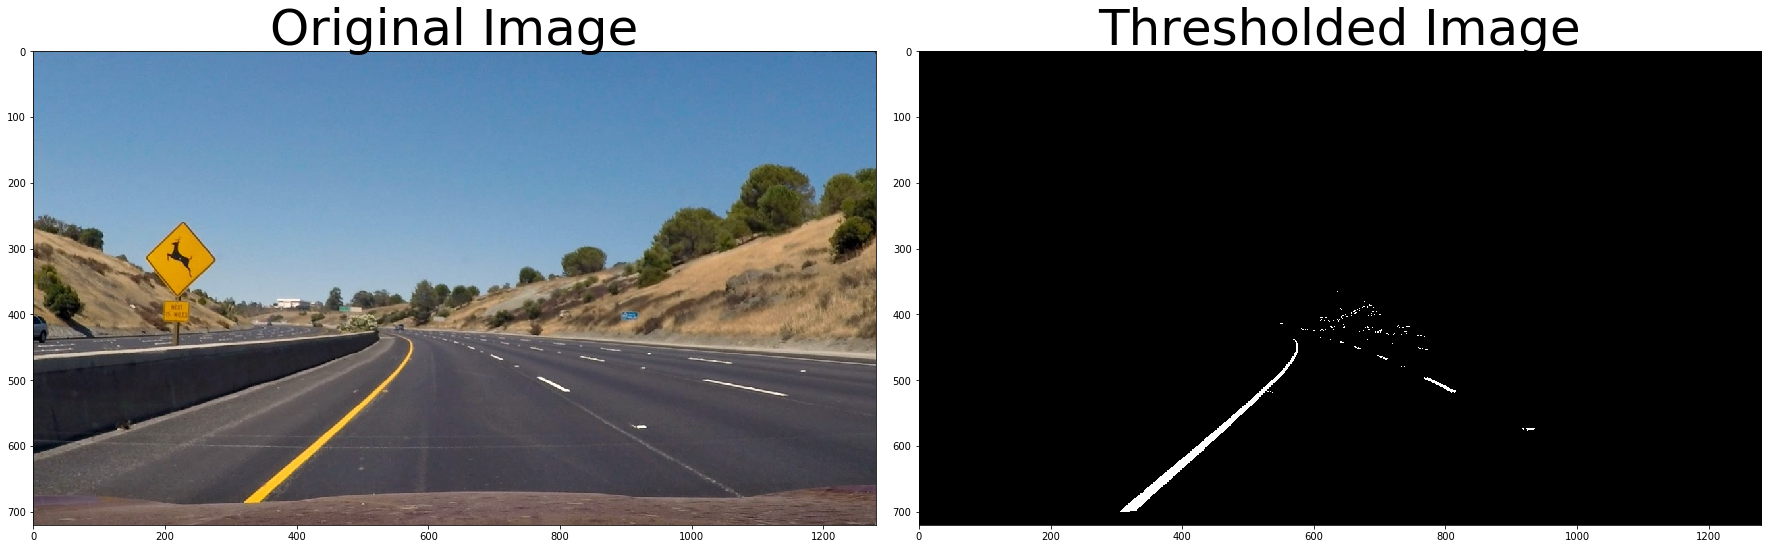

In [40]:
thresholded_img = get_threshold_image(undistortedImg)

# Plot the 2 images side by side
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(thresholded_img, cmap='gray')
ax2.set_title('Thresholded Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f.savefig('output_images/thresholded_image')

# Perspective Transformatio

In [41]:
imgCoor = np.float32([(580, 460), (205, 720), (1110, 720), (703, 460)])
realCoor = np.float32([(320, 0), (320, 720), (960, 720), (960, 0)])
perspectiveTransformer = lfpipe.PerspectiveTransform(imgCoor, realCoor)


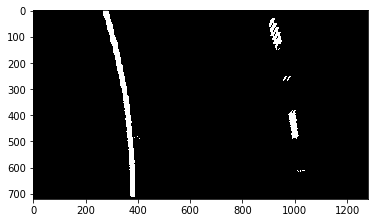

In [42]:
transformed = perspectiveTransformer.process(thresholded_img)
plt.imshow(transformed, cmap='gray')
plt.savefig('output_images/perspective_transformed.jpg')


# Lane Finding

In [43]:
laneFittingPipe = lfpipe.LaneFinding()

372 1000


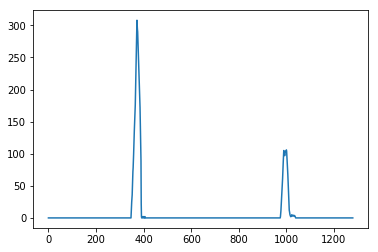

In [44]:
# visualize the steps 
# step 1, plot the histogram and find the left x and right x
hist, leftX, rightX = laneFittingPipe.findHistogram(transformed)
plt.plot(hist)
print (leftX, rightX)

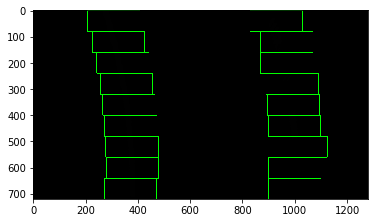

In [45]:
# step2 sliding window search
_, _, _, _, outImg = laneFittingPipe.slidingWindowFindLanePixel(transformed)
plt.imshow(outImg)

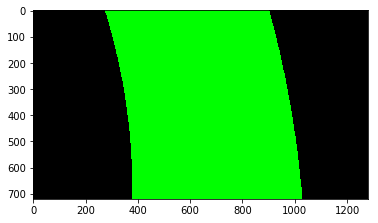

In [46]:
masked_result = laneFittingPipe.process(transformed)
plt.imshow(masked_result)
plt.savefig('output_images/masked_lane.jpg')

In [47]:
print (laneFittingPipe.left_fit)
print (laneFittingPipe.right_fit)

[ -2.25086997e-04   3.07168179e-01   2.75214778e+02]
[ -1.34016017e-04   2.72178385e-01   9.02293440e+02]


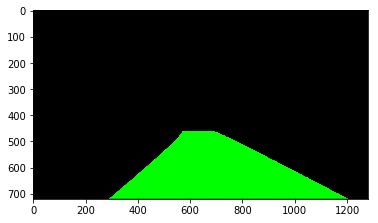

In [48]:
undistored_mask = perspectiveTransformer.unWrap(masked_result)
plt.imshow(undistored_mask)

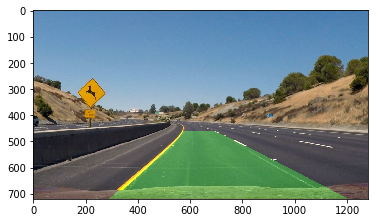

In [49]:
final_result = cv2.addWeighted(img, 1, undistored_mask, 0.3, 0)

plt.imshow(final_result)

In [50]:
print (laneFittingPipe.getAverageCurvature())
print (laneFittingPipe.getOffsetMsg())

Radius of curvature: 977.62 m
Center offset: 1.82 m


# Full Pipeline

In [30]:
class FullPipe(object):
    def __init__(self):
        self.cameraCalibPipe = lfpipe.CameraCalibration()
        self.perspectiveTransPipe = lfpipe.PerspectiveTransform()
        self.laneFindPipe = lfpipe.LaneFinding()
    
    def process(self, image):
        try:
            cmCalibratedImg = self.cameraCalibPipe.process(image)
            thresholdedImg = self._getThresholdImage(cmCalibratedImg)
            perspectiveTransformedImg = self.perspectiveTransPipe.process(thresholdedImg)

            laneFindingMaskImg = self.laneFindPipe.process(perspectiveTransformedImg)

            undistored_mask = self.perspectiveTransPipe.unWrap(laneFindingMaskImg)
            final_result = cv2.addWeighted(image, 1, undistored_mask, 0.3, 0)

            curvatureStr = self.laneFindPipe.getAverageCurvature()
            offsetStr = self.laneFindPipe.getOffsetMsg()

            cv2.putText(final_result, curvatureStr, (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
            cv2.putText(final_result, offsetStr, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)

            return final_result
        except Exception as e:
            print ("something is wrong")
            print (str(e))
            return image
    
    def _getThresholdImage(self, image):
        '''
        input: img we need to process 
        output: gradient & color filter processes image
        '''

        # apply graident threshold on horizontal gradient
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        height, width = gray.shape

        gfilterX = lfpipe.SobelFilter('x', thresh_min=10, thresh_max=200)
        gfilterdir = lfpipe.SobelFilter('dir', thresh_min=np.pi/6, thresh_max=np.pi/2)

        combined_condition = (gfilterX.process(gray) == 1) & (gfilterdir.process(gray) == 1)

        # apply color filter 
        # R & G thresholds so that yellow lanes are detected well.
        color_combined = np.zeros_like(image[:, :, 0])

        rfilter = lfpipe.ColorFilter('R', min_thresh=150)
        gfilter = lfpipe.ColorFilter('G', min_thresh=150)

        rMask = rfilter.process(image)
        gMask = gfilter.process(image)

        r_g_condition = rMask & gMask


        lfilter = lfpipe.ColorFilter('L', min_thresh=100)
        sfilter = lfpipe.ColorFilter('S', min_thresh=120)

        smask, lmask = sfilter.process(image), lfilter.process(image)

        # combine all the thresholds
        # A pixel should either be a yellowish or whiteish
        # And it should also have a gradient, as per our thresholds
        color_combined[(r_g_condition& smask) & (lmask | combined_condition)] = 1

        # apply the region of interest mask
        mask = np.zeros_like(color_combined)
        region_of_interest_vertices = np.array([[0,height-1], [width/2, int(0.5*height)], [width-1, height-1]], dtype=np.int32)
        cv2.fillPoly(mask, [region_of_interest_vertices], 1)
        thresholded = cv2.bitwise_and(color_combined, mask)

        return thresholded


found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found


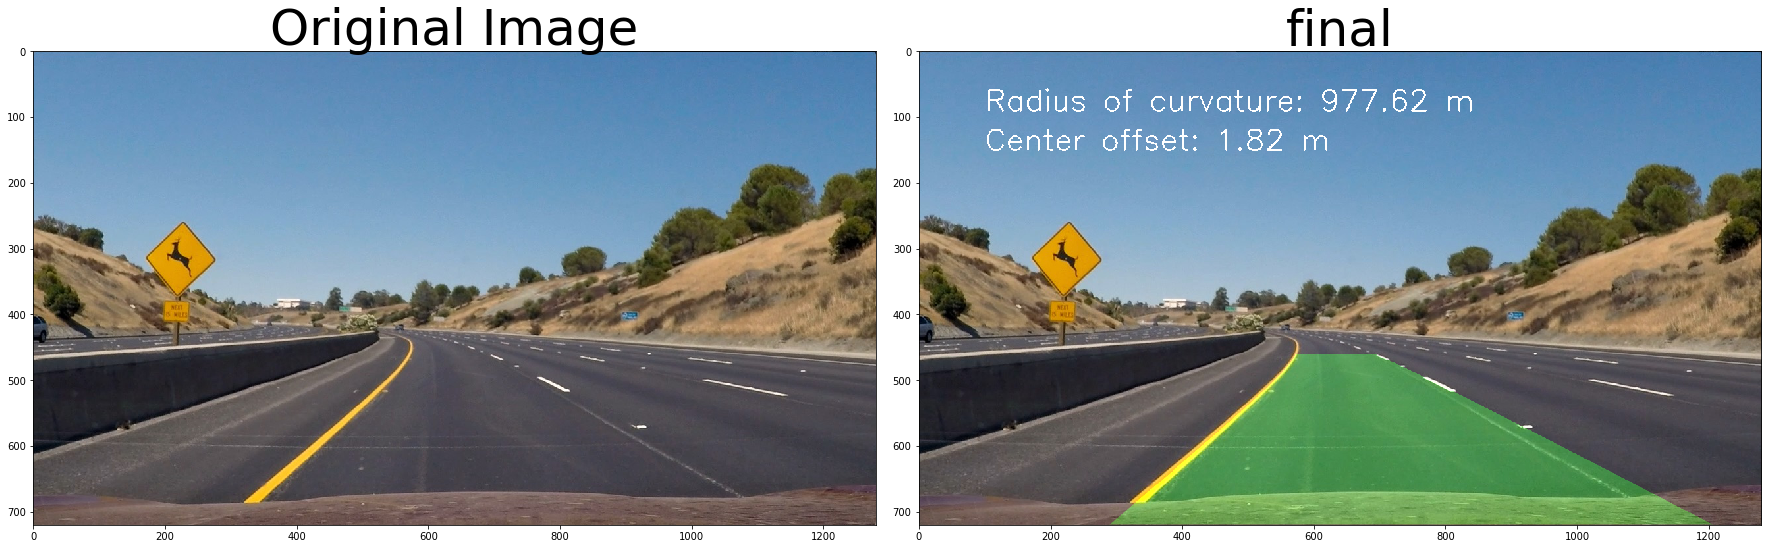

In [32]:
fullpipe = FullPipe()
img = mpimg.imread('test_images/test2.jpg')
result = fullpipe.process(img)

 #Plot the 2 images side by side
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(result)
ax2.set_title('final', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f.savefig('output_images/final_result.jpg')

# Pipeline Video

In [28]:
from moviepy.editor import VideoFileClip

In [19]:
fullpipe = FullPipe()
output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")

white_clip = clip1.fl_image(fullpipe.process)
%time white_clip.write_videofile(output, audio=False)

found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [06:14<00:00,  3.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 3min 15s, sys: 51.1 s, total: 4min 7s
Wall time: 6min 17s


In [31]:
fullpipe = FullPipe()
output = 'challenge_video_output.mp4'
clip1 = VideoFileClip("challenge_video.mp4")

white_clip = clip1.fl_image(fullpipe.process)
%time white_clip.write_videofile(output, audio=False)

found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4



 27%|██▋       | 132/485 [00:31<01:22,  4.27it/s]

something is wrong
expected non-empty vector for x



 28%|██▊       | 134/485 [00:31<01:22,  4.24it/s]

something is wrong
expected non-empty vector for x



 28%|██▊       | 135/485 [00:32<01:24,  4.15it/s]

something is wrong
expected non-empty vector for x



 28%|██▊       | 136/485 [00:32<01:21,  4.31it/s]

something is wrong
expected non-empty vector for x



 28%|██▊       | 137/485 [00:32<01:21,  4.29it/s]

something is wrong
expected non-empty vector for x



 28%|██▊       | 138/485 [00:32<01:22,  4.21it/s]

something is wrong
expected non-empty vector for x



 29%|██▊       | 139/485 [00:33<01:19,  4.35it/s]

something is wrong
expected non-empty vector for x



 29%|██▉       | 140/485 [00:33<01:19,  4.31it/s]

something is wrong
expected non-empty vector for x



 29%|██▉       | 141/485 [00:33<01:22,  4.18it/s]

something is wrong
expected non-empty vector for x



 29%|██▉       | 142/485 [00:33<01:20,  4.29it/s]

something is wrong
expected non-empty vector for x



 29%|██▉       | 143/485 [00:34<01:20,  4.23it/s]

something is wrong
expected non-empty vector for x



 30%|██▉       | 144/485 [00:34<01:21,  4.21it/s]

something is wrong
expected non-empty vector for x



 30%|██▉       | 145/485 [00:34<01:21,  4.18it/s]

something is wrong
expected non-empty vector for x



 30%|███       | 146/485 [00:34<01:22,  4.13it/s]

something is wrong
expected non-empty vector for x



 94%|█████████▎| 454/485 [01:56<00:07,  3.88it/s]


100%|██████████| 485/485 [02:04<00:00,  3.79it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 1min 15s, sys: 1.06 s, total: 1min 16s
Wall time: 2min 7s


In [25]:
fullpipe = FullPipe()
output = 'harder_challenge_video_output.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")

white_clip = clip1.fl_image(fullpipe.process)
%time white_clip.write_videofile(output, audio=False)

found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4



 77%|███████▋  | 921/1200 [05:18<01:39,  2.80it/s]

TypeError: expected non-empty vector for x